## BoilerPlate command

It’s standard practice to start the notebook with the following three lines; they ensure that any edits to libraries you make are reloaded here automatically, and also that any charts or images displayed are shown in this notebook.



In [1]:
%reload_ext autoreload
%autoreload 2
%matplotlib inline

## Importing Fast AI library

Let’s import fastai library and define our batch_size parameter to 64. Usually, image databases are enormous, so we need to feed these images into a GPU using batches, batch size 16428 means that we will feed 64 images at once to update parameters of our deep learning model. If you are running out of memory because of smaller GPU RAM, you can reduce batch size to 32 or 16.

In [2]:
from fastai.vision.all import *
from lenet import *
from sklearn.metrics import classification_report
from jupyterthemes import jtplot
jtplot.style(theme="monokai", context='notebook', ticks=True, grid=False)
bs=512

## Downloading Dataset

In [4]:
path = untar_data(URLs.MNIST, dest="../data/");
path

Path('../data/mnist_png')

Let's look inside the training folder. Data is split by digits 1 to 9 in a different folder.

In [5]:
path.ls()

(#3) [Path('../data/mnist_png/models'),Path('../data/mnist_png/testing'),Path('../data/mnist_png/training')]

In [6]:
(path/'training').ls()

(#10) [Path('../data/mnist_png/training/0'),Path('../data/mnist_png/training/1'),Path('../data/mnist_png/training/2'),Path('../data/mnist_png/training/3'),Path('../data/mnist_png/training/4'),Path('../data/mnist_png/training/5'),Path('../data/mnist_png/training/6'),Path('../data/mnist_png/training/7'),Path('../data/mnist_png/training/8'),Path('../data/mnist_png/training/9')]

Within each digit folder, we have images.

In [7]:
(path/'training/0').ls()[1:5]

(#4) [Path('../data/mnist_png/training/0/1000.png'),Path('../data/mnist_png/training/0/10005.png'),Path('../data/mnist_png/training/0/10010.png'),Path('../data/mnist_png/training/0/10022.png')]

## Importing Data

In [8]:
ds_tfms = aug_transforms(do_flip=False, max_rotate=15, max_zoom=1.1, max_lighting=0.2, max_warp=0.2)
mnist = DataBlock(blocks=(ImageBlock(cls=PILImageBW), CategoryBlock), 
                  get_items=get_image_files, 
                  #splitter=RandomSplitter(0.2),
                  splitter=GrandparentSplitter(train_name='training', valid_name='testing'),
                  get_y=parent_label,
                  item_tfms=Resize(28),
                  batch_tfms=ds_tfms)
dls = mnist.dataloaders(path, bs=bs)

In [10]:
dls.train_ds

(#60000) [(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0))...]

In [11]:
dls.valid_ds

(#10000) [(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0)),(PILImageBW mode=L size=28x28, TensorCategory(0))...]

(#10) ['0','1','2','3','4','5','6','7','8','9']
10


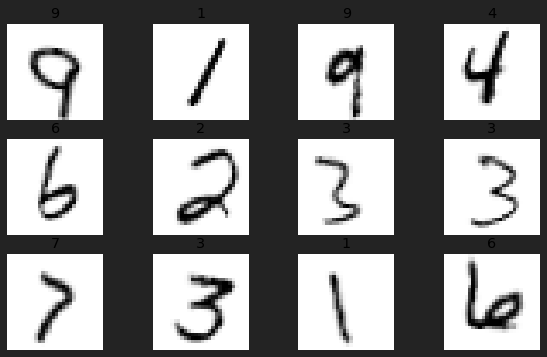

In [14]:
print(dls.vocab) ## Prints class labels
print(dls.c) ## Prints number of classes
dls.show_batch(max_n=12, figsize=(10,6)) ## Show sample data

## About the model

LeNet architecture was first introduced by first introduced by LeCun et al. in their 1998 paper, Gradient-Based Learning Applied to Document Recognition. LeNet is quite a simple architecture as represented in image below.
<img src="https://blog.dataiku.com/hs-fs/hubfs/Dataiku%20Dec%202016/Image/le_net.png?width=620&name=le_net.png">

The architecture can represented by following notation - 

(CONV=>RELU=>POOL)*2 => (FC=>RELU) => FC=>SOFTMAX

## Training the model

We have defined our shallownet model in lenet.py file, now we need to train it. We can use FastAI's *Learner* function which makes it easier to leverage modern enhancement in optimization methods and many other neat tricks like  1-Cycle style training as highlighted in [Leslie Smith's paper](https://arxiv.org/pdf/1803.09820.pdf) for faster convergence. Let's define our Learner class -

In [15]:
## Defining the learner
lenet_learner = Learner(
    dls = dls, 
    model=LeNet(n_class=dls.c, size=28, in_channels=1), 
    pretrained=False, 
    loss_func=F.cross_entropy, 
    model_dir=path/"models",
    metrics=accuracy)

In [16]:
lenet_learner.summary()

LeNet (Input shape: ['512 x 1 x 28 x 28'])
Layer (type)         Output Shape         Param #    Trainable 
Conv2d               512 x 20 x 28 x 28   520        True      
________________________________________________________________
Conv2d               512 x 50 x 14 x 14   25,050     True      
________________________________________________________________
Linear               512 x 500            1,225,500  True      
________________________________________________________________
Linear               512 x 10             5,010      True      
________________________________________________________________

Total params: 1,256,080
Total trainable params: 1,256,080
Total non-trainable params: 0

Optimizer used: <function Adam at 0x7f3194e69ee0>
Loss function: <function cross_entropy at 0x7f310ab50f70>

Callbacks:
  - TrainEvalCallback
  - Recorder
  - ProgressCallback

SuggestedLRs(lr_min=0.014454397559165954, lr_steep=0.0063095735386013985)

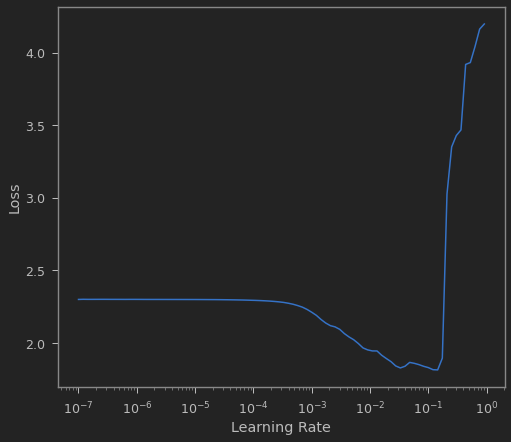

In [17]:
## Finidng Ideal learning late
lenet_learner.lr_find()

In [18]:
lenet_learner.fit_one_cycle(5,1e-2)

epoch,train_loss,valid_loss,accuracy,time
0,0.375773,0.085624,0.972300,01:43
1,0.124525,0.037279,0.988900,01:11
2,0.066044,0.028014,0.989700,01:18
3,0.041174,0.021155,0.992600,01:15
4,0.027927,0.017221,0.994500,01:14


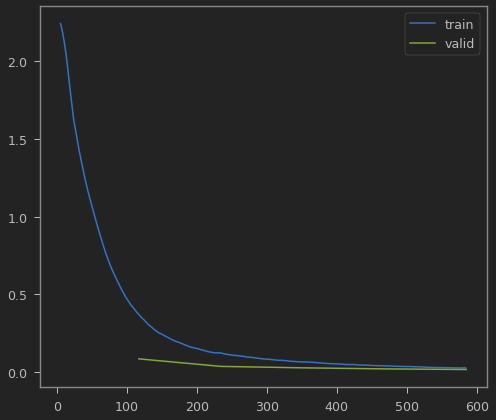

In [19]:
lenet_learner.recorder.plot_loss()

In [20]:
interp = ClassificationInterpretation.from_learner(lenet_learner)
print(classification_report(np.array(interp.preds).argmax(axis=1), interp.targs))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00       980
           1       1.00      1.00      1.00      1134
           2       1.00      1.00      1.00      1034
           3       1.00      0.99      0.99      1018
           4       0.99      1.00      1.00       981
           5       0.99      0.99      0.99       888
           6       0.99      1.00      0.99       951
           7       0.99      0.99      0.99      1030
           8       1.00      0.99      0.99       980
           9       0.99      1.00      0.99      1004

    accuracy                           0.99     10000
   macro avg       0.99      0.99      0.99     10000
weighted avg       0.99      0.99      0.99     10000

